<a href="https://colab.research.google.com/github/coughlinjennie/data71200/blob/main/Data71200_project3_Coughlin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Load data and libraries

In [ ]:
#Load libraries

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import requests
import io
import matplotlib.pyplot as plt

!pip install -U scikit-learn==1.4

import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
!pip install mglearn
import mglearn

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 12.1 MB/s eta 0:00:00


In [ ]:
#Load data

#Import the data, sourced from Kaggle and stored in my GitHub
url = "https://raw.githubusercontent.com/coughlinjennie/data71200/main/projects/nyhousing.csv" # Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content
#Load the data

housing_master = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [ ]:
# Delete all rows where column 'TYPE' has certain values
indexType = housing_master[ (housing_master['TYPE'] == "For sale") | (housing_master['TYPE'] == "Contingent") | (housing_master['TYPE'] == "Land for sale") | (housing_master['TYPE'] == "Foreclosure") | (housing_master['TYPE'] == "Pending") | (housing_master['TYPE'] == "Coming Soon") | (housing_master['TYPE'] == "Mobile house for sale") ].index
housing_master.drop(indexType , inplace=True)

#Set the labels on TYPE

housing_label = housing_master["TYPE"]

#Set the data
housing = housing_master.drop("TYPE", axis=1)

#Divide the data into training and testing sets
from sklearn.model_selection import train_test_split

housing_train, housing_test, housing_label_train, housing_label_test = train_test_split(housing, housing_label, test_size=0.3, stratify=housing_label, random_state=42)

# Create a list of redundant column names to drop from the training data only
to_drop = ["LONGITUDE", "LATITUDE", "ADDRESS", "ADMINISTRATIVE_AREA_LEVEL_2", "LOCALITY", "SUBLOCALITY", "FORMATTED_ADDRESS", "MAIN_ADDRESS", "STATE", "STREET_NAME","LONG_NAME","BROKERTITLE"]

# Drop those columns from the dataset
housing_subset = housing_train.drop(to_drop, axis = 1)
h_test_subset = housing_test.drop(to_drop, axis = 1)

#Drop all properties that sold for more than $1B from training data only

housing_clean = housing_subset[housing_subset['PRICE'] <= 100000000]
label_train_clean = housing_label_train[housing_subset['PRICE'] <= 100000000]


In [ ]:
#Scale features as needed

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
housing_scaled = scaler.fit_transform(housing_clean)
housing_test_scaled = scaler.transform(h_test_subset)

#Step 2: PCA for feature selection

In [ ]:
# keep the components that explain 95% of the variance in the data

from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
# fit PCA model to data
housing_pca = pca.fit_transform(housing_scaled)
housing_test_pca = pca.transform(housing_test_scaled)


In [ ]:
#Run the Decision Tree model from Project 2 again with PCA data
from sklearn.tree import DecisionTreeClassifier

model3 = DecisionTreeClassifier(random_state=0).fit(housing_pca, label_train_clean)

print("Accuracy on training set: {:.2f}".format(model3.score(housing_pca, label_train_clean)))
print("Accuracy on test set: {:.2f}".format(model3.score(housing_test_pca, housing_label_test)))


Accuracy on training set: 0.99
Accuracy on test set: 0.58


In [ ]:
#Evaluate model performance vs. original

model = DecisionTreeClassifier(random_state=0).fit(housing_scaled, label_train_clean)
print("Accuracy on training set: {:.2f}".format(model.score(housing_scaled, label_train_clean)))
print("Accuracy on test set: {:.2f}".format(model.score(housing_test_scaled, housing_label_test)))



Accuracy on training set: 0.99
Accuracy on test set: 0.61


In both cases the training set continues to overfit and the testing data performs much worse. Using PCA actually doesn't seem to improve this model, although it doesn't make it much worse. I'm going to re-run with the two principal components PCA to see if that improves the model.

In [ ]:
# keep the first two principal components of the data
pca2 = PCA(n_components=2)


# fit PCA model to data
housing_pca2 = pca2.fit_transform(housing_scaled)
housing_test_pca2 = pca2.transform(housing_test_scaled)

model2 = DecisionTreeClassifier(random_state=0).fit(housing_pca2, label_train_clean)

print("Accuracy on training set: {:.2f}".format(model2.score(housing_pca2, label_train_clean)))
print("Accuracy on test set: {:.2f}".format(model2.score(housing_test_pca2, housing_label_test)))


Accuracy on training set: 0.99
Accuracy on test set: 0.56


This model did even worse. My working theory is that as much as the training data is overfitted, it still needs all the variables I'm working with in the model. In Project 2, I theorized that the lack of location data was probably a factor in the poor model performance, and this is more weight toward that theory. Location data and broker name are the only additional variables in the original data set, and location seems more likely as a useful variable because neighborhoods tend to have similar types of housing near each other.

To make this model useful enough to be worth applying, I would aggregate the ZIP codes into bigger neighborhood clusters, and perhaps add borough as a second collection of one-hot-encoded variables. The same code could be used for both, a series of if-else statements in a loop that would look at the ZIP code for the property and based on the value, add a NEIGHBORHOOD and BOROUGH value to the row. It would take a fair amount of work to set up the best way to aggregate the 179 ZIP codes, so beyond the scope of this project, but the code could be re-used for any location-based models for the city.

#Step 3: Apply Clustering to Data and Visualize Output

##K-means clustering

Text(0, 0.5, 'Feature 1')

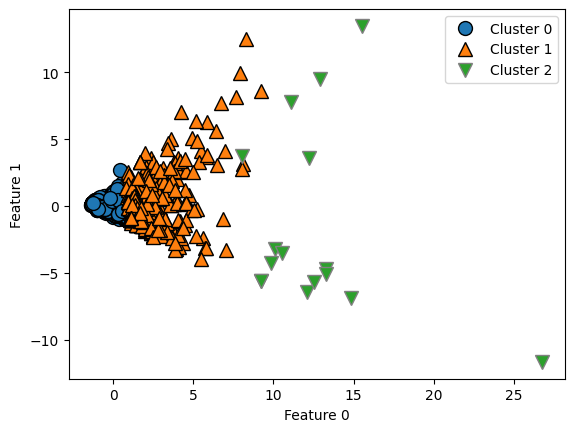

In [ ]:
#Run the model with PCA applied
from sklearn.cluster import KMeans

# build the clustering model
kmeans = KMeans(n_clusters=3)
kmeans.fit(housing_pca)
assignments=kmeans.labels_

mglearn.discrete_scatter(housing_pca[:, 0], housing_pca[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

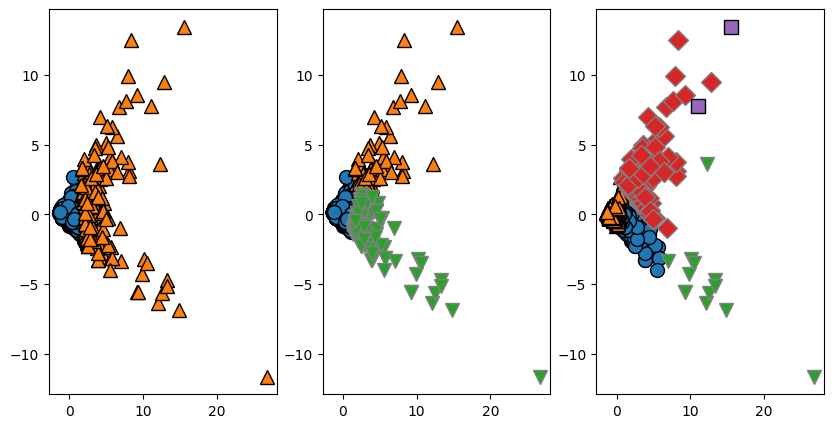

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# using two cluster centers:
kmeans = KMeans(n_clusters=2)
kmeans.fit(housing_pca)
assignments = kmeans.labels_

mglearn.discrete_scatter(housing_pca[:, 0], housing_pca[:, 1], assignments, ax=axes[0])

# using three cluster centers:
kmeans = KMeans(n_clusters=3)
kmeans.fit(housing_pca)
assignments=kmeans.labels_

mglearn.discrete_scatter(housing_pca[:, 0], housing_pca[:, 1], assignments, ax=axes[1])

# using five cluster centers:
kmeans = KMeans(n_clusters=5)
kmeans.fit(housing_pca)
assignments = kmeans.labels_

mglearn.discrete_scatter(housing_pca[:, 0], housing_pca[:, 1], assignments, ax=axes[2])

The sideways V-shape is interesting, and I wish I could see how these clusters map onto the actual labels. Three and five both have some suggestive elements, although the points are so tightly clustered that it makes it tough to get a sense of the side point of the V.

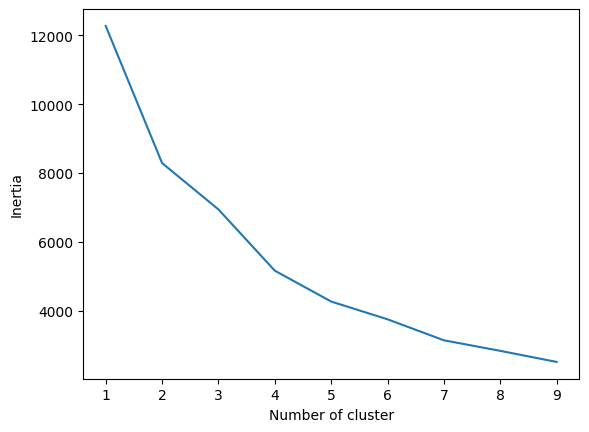

In [ ]:
inertiaVals = {}

for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(housing_pca)
    inertiaVals[k] = kmeansTmp.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

My elbow plot looks more like somebody holding their arm with a gentle curve, which is probably because the data skews heavily toward a few of the labels, with much smaller numbers of the remaining ones.

Text(0, 0.5, 'Feature 1')

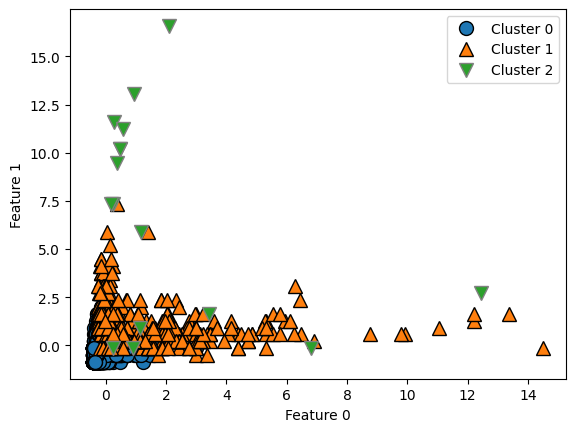

In [17]:
#Run the model without PCA applied
kmeans = KMeans(n_clusters=3)
kmeans.fit(housing_scaled)
assignments=kmeans.labels_

mglearn.discrete_scatter(housing_scaled[:, 0], housing_scaled[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

These clusters seem like they aren't as good — the green triangles are just kind of scattered around.

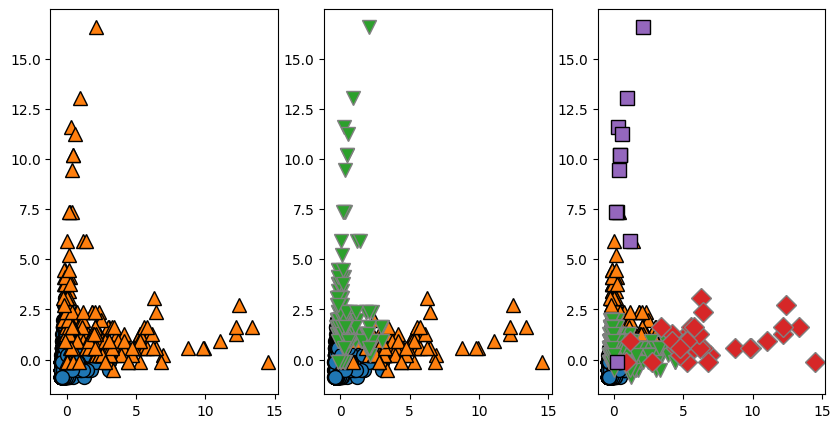

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# using two cluster centers:
kmeans = KMeans(n_clusters=2)
kmeans.fit(housing_scaled)
assignments = kmeans.labels_

mglearn.discrete_scatter(housing_scaled[:, 0], housing_scaled[:, 1], assignments, ax=axes[0])

# using three cluster centers:
kmeans = KMeans(n_clusters=3)
kmeans.fit(housing_scaled)
assignments=kmeans.labels_

mglearn.discrete_scatter(housing_scaled[:, 0], housing_scaled[:, 1], assignments, ax=axes[1])

# using five cluster centers:
kmeans = KMeans(n_clusters=5)
kmeans.fit(housing_scaled)
assignments = kmeans.labels_

mglearn.discrete_scatter(housing_scaled[:, 0], housing_scaled[:, 1], assignments, ax=axes[2])

It's the bottom left corner of a square here, but there's still the general shape of a major cluster with two extensions coming out on an angle. Again, everything is so tightly packed at the main corner, it's tough to really understand what's going on.

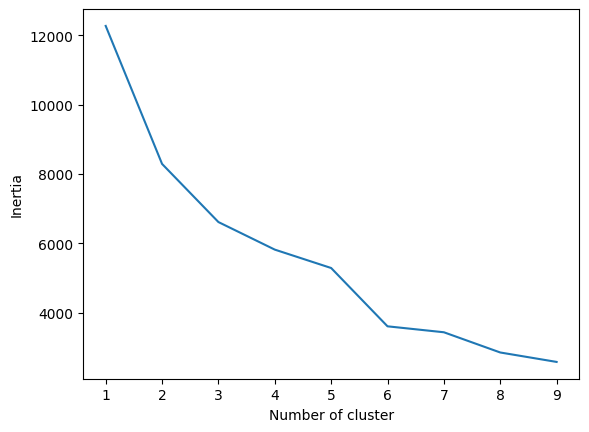

In [19]:
inertiaVals = {}

for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(housing_scaled)
    inertiaVals[k] = kmeansTmp.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

This elbow plot looks more like an arm with a compound fracture.

##Agglomerate/hierarchical

Text(0, 0.5, 'Feature 1')

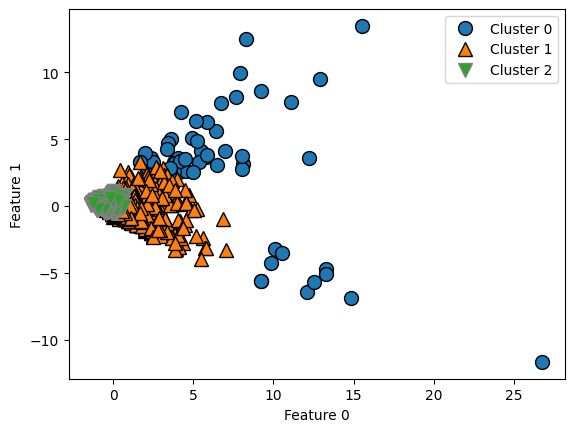

In [20]:
#Run the model with PCA applied
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(housing_pca)

mglearn.discrete_scatter(housing_pca[:, 0], housing_pca[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Cluster distance')

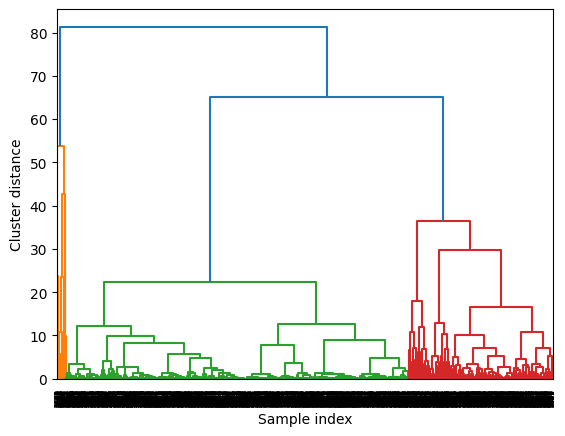

In [21]:
# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward

# Apply the ward clustering to the data array X
# The SciPy ward function returns an array that specifies the distances
# bridged when performing agglomerative clustering
linkage_array = ward(housing_pca)
# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array)

# mark the cuts in the tree that signify two or three clusters

plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

This took a long time to run, which makes sense with the number of points. While this dendrogram sheds some light on the points we couldn't see because they were so tightly clustered, it almost raises more questions than it answers. The orange is that really tightly packed point that the rest spokes out from. There definitely seems to be a difference between the green and the red, and I wonder what that bifurcation within the green represents.

Text(0, 0.5, 'Feature 1')

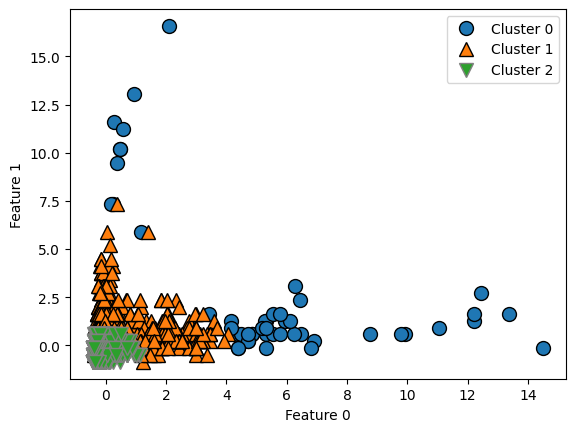

In [22]:
#Run the model without PCA applied
agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(housing_scaled)

mglearn.discrete_scatter(housing_scaled[:, 0], housing_scaled[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Cluster distance')

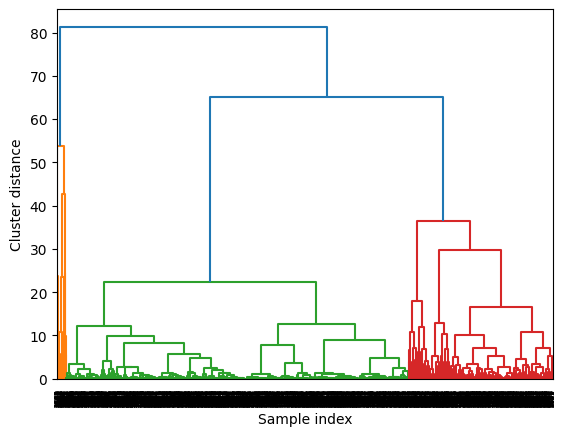

In [23]:
# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward

# Apply the ward clustering to the data array X
# The SciPy ward function returns an array that specifies the distances
# bridged when performing agglomerative clustering
linkage_array = ward(housing_scaled)
# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array)

# mark the cuts in the tree that signify two or three clusters

plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

The dendrograms for the scaled vs. pca look very similar, which maybe points to a reason that using PCA for feature selection didn't yield any improvements.

##DBSCAN

Text(0, 0.5, 'Feature 1')

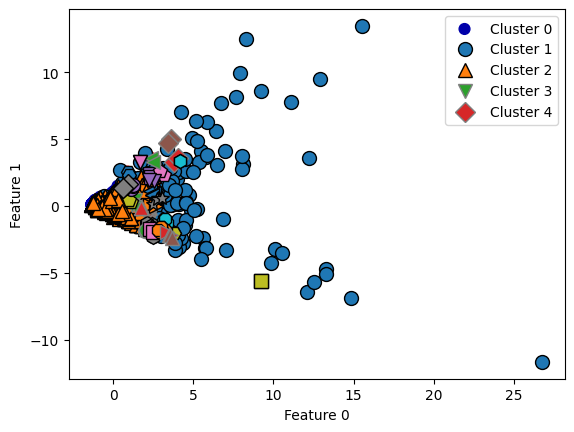

In [24]:
#Run the model with PCA applied
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(min_samples=2,eps=0.5)
clusters = dbscan.fit_predict(housing_pca)

# plot the cluster assignments
plt.scatter(housing_pca[:, 0], housing_pca[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

mglearn.discrete_scatter(housing_pca[:, 0], housing_pca[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Feature 1')

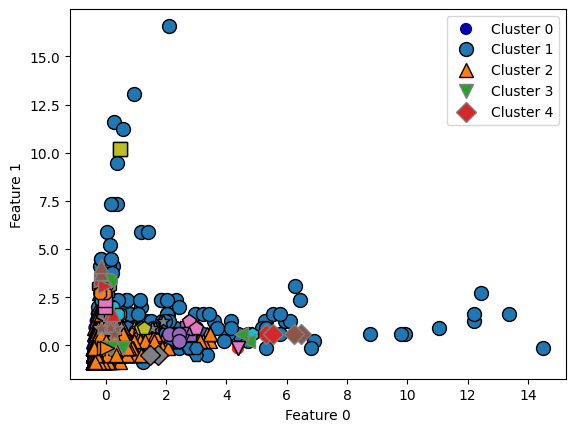

In [25]:
#Run the model without PCA applied

dbscan = DBSCAN(min_samples=2,eps=0.5)
clusters = dbscan.fit_predict(housing_scaled)

# plot the cluster assignments
plt.scatter(housing_scaled[:, 0], housing_scaled[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

mglearn.discrete_scatter(housing_scaled[:, 0], housing_scaled[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

DBSCAN doesn't seem to be a useful option for this particular data set. Both scatterplots mostly look like a box of colored sprinkles got dumped in a box.

##Comparing clustering algorithms: ARI

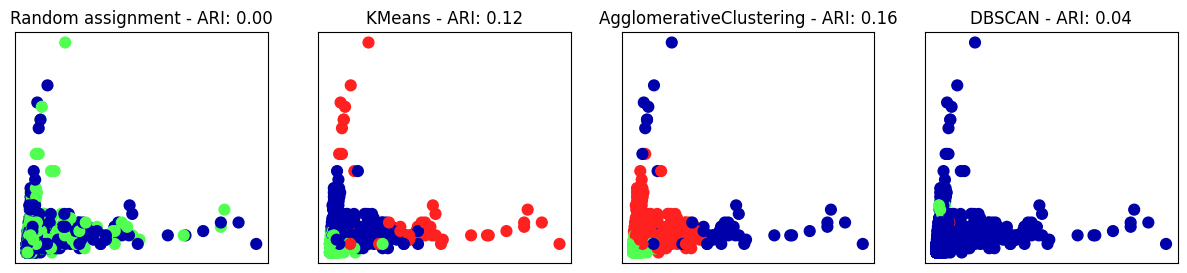

In [27]:
from sklearn.metrics.cluster import adjusted_rand_score

# Rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(housing_clean)
X_scaled = scaler.transform(housing_clean)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3),
              DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(housing_clean))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(label_train_clean, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(label_train_clean, clusters)))

When I compare with ground truth, they're all terrible. Really, truly terrible.

##Comparing clustering algorithms: Silhouette configuration

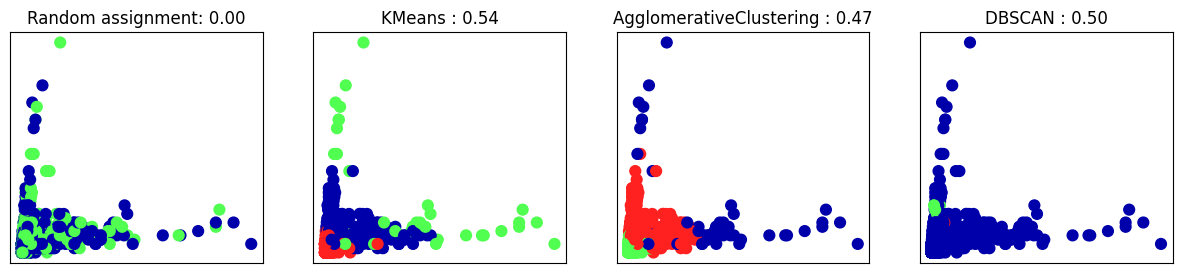

In [28]:
from sklearn.metrics.cluster import silhouette_score

# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(housing_clean)
X_scaled = scaler.transform(housing_clean)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(housing_clean))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_scaled, clusters)))

Without ground truth, the perfomance improves dramatically, but never really improves beyond a coin flip. In a dataset with six categories, that's still probably somewhat useful, but the model would definitely need additional features added to try and improve the performance before using in any real sense.

My biggest takeaway from the series of projects is that I need to find a way to use more features from the original data for any sort of machine learning purpose to determine if machine learning is a viable option for this sort of task. It might not be.